In [1]:
# This Python 2 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,SGDClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.metrics import log_loss
# Any results you write to the current directory are saved as output.

%matplotlib inline

['train.json', 'test.json', 'sample_submission.csv']


Using TensorFlow backend.


In [2]:
train = pd.read_json('../input/train.json', orient='columns')
test = pd.read_json('../input/test.json', orient='columns')
sample_submission = pd.read_csv("../input/sample_submission.csv")

In [3]:
display(train.head())
display(test.head())
display(sample_submission.head())

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


,id,cuisine
0,35203,italian
1,17600,italian
2,35200,italian
3,17602,italian
4,17605,italian


## PreProcessing

In [4]:
## convert multi-word ingredient into single word by substituting underscore on place of space
def sub_space(x):
    temp_value = list()
    for i in x:
        temp_value.append(re.sub(r'[^0-9a-zA-Z]+','_',i.lower()))
    return temp_value

train['ingredients_new'] = train['ingredients'].apply(sub_space)
test['ingredients_new'] = test['ingredients'].apply(sub_space)

## convert list of ingredients into a sentence
def convert_list_to_sent(x):
    return ' '.join(x)

train['ingredient_sent'] = train['ingredients_new'].apply(convert_list_to_sent)
test['ingredient_sent'] = test['ingredients_new'].apply(convert_list_to_sent)

display(train.head())
display(test.head())


,cuisine,id,ingredients,ingredients_new,ingredient_sent
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes...",romaine_lettuce black_olives grape_tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","[plain_flour, ground_pepper, salt, tomatoes, g...",plain_flour ground_pepper salt tomatoes ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking_oil, g...",eggs pepper salt mayonaise cooking_oil green_c...
3,indian,22213,"[water, vegetable oil, wheat, salt]","[water, vegetable_oil, wheat, salt]",water vegetable_oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","[black_pepper, shallots, cornflour, cayenne_pe...",black_pepper shallots cornflour cayenne_pepper...


,id,ingredients,ingredients_new,ingredient_sent
0,18009,"[baking powder, eggs, all-purpose flour, raisi...","[baking_powder, eggs, all_purpose_flour, raisi...",baking_powder eggs all_purpose_flour raisins m...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...","[sugar, egg_yolks, corn_starch, cream_of_tarta...",sugar egg_yolks corn_starch cream_of_tartar ba...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...","[sausage_links, fennel_bulb, fronds, olive_oil...",sausage_links fennel_bulb fronds olive_oil cub...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...","[meat_cuts, file_powder, smoked_sausage, okra,...",meat_cuts file_powder smoked_sausage okra shri...
4,35687,"[ground black pepper, salt, sausage casings, l...","[ground_black_pepper, salt, sausage_casings, l...",ground_black_pepper salt sausage_casings leeks...


### Get Train and Validation data

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train['ingredient_sent'], train['cuisine'], test_size=0.33, random_state=42)

In [6]:
## Getting Features using TfIDFVectorizer
tfidf_vect = TfidfVectorizer(lowercase=True,binary=True)

# binary value in feature set
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_val_tfidf = tfidf_vect.transform(X_val)
X_test_tfidf = tfidf_vect.transform(test['ingredient_sent'])


In [7]:
lb = LabelEncoder()
y_train_encode = lb.fit_transform(y_train)
y_val_encode = lb.transform(y_val)

y_train_dummy = np_utils.to_categorical(y_train_encode)
y_val_dummy = np_utils.to_categorical(y_val_encode)

In [8]:
input_shape = X_train_tfidf.shape[1]
def model_structure1():    
    mdl = Sequential()
    mdl.add(Dense(512, init='glorot_uniform', activation='relu',input_shape=(input_shape,)))
    mdl.add(Dropout(0.5))
    mdl.add(Dense(128, init='glorot_uniform', activation='relu'))
    mdl.add(Dropout(0.5))
    mdl.add(Dense(20, activation='softmax'))
    mdl.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    mdl.summary()
    return mdl 

In [9]:
print("Compile model ...")
estimator = KerasClassifier(build_fn=model_structure1, epochs=10, batch_size=128)

Compile model ...


In [10]:
# estimator.fit(X_train_tfidf.toarray(), y_train_dummy)
history = estimator.fit(X_train_tfidf.toarray(), y_train_dummy,\
                        validation_data=(X_val_tfidf.toarray(),y_val_dummy))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", input_shape=(5988,), kernel_initializer="glorot_uniform")`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="glorot_uniform")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3066368   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
Total params: 3,134,612
Trainable params: 3,134,612
Non-trainable params: 0
_________________________________________________________________
Train on 26648 samples, validate on 13126 samples
Epoch 1/10
26648/26648 [==============================] - 12s 462us/step - loss: 2

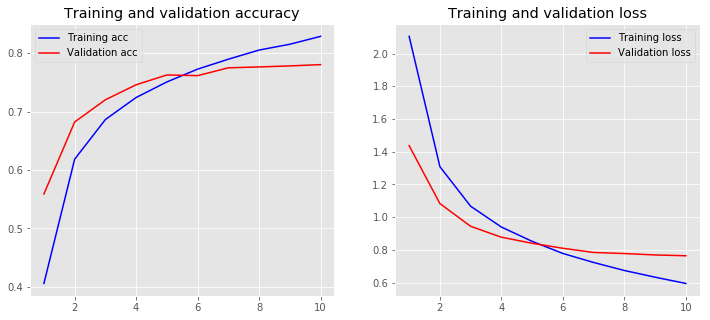

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [12]:
# Predictions on train and validation data

mnb_train_prediction = estimator.predict_proba(X_train_tfidf.toarray())
mnb_val_prediction = estimator.predict_proba(X_val_tfidf.toarray())

mnb_tr_pred_value = estimator.predict(X_train_tfidf.toarray())
mnb_val_pred_value = estimator.predict(X_val_tfidf.toarray())
mnb_test_pred_value = estimator.predict(X_test_tfidf.toarray())
print("=====")
print("Log loss for TfIDFVectorizer features in MLP for Training set {}".format(log_loss(y_train_encode,mnb_train_prediction)))
print("Log loss for TfIDFVectorizer features in MLP for validation set {}".format(log_loss(y_val_encode,mnb_val_prediction)))
print("Accuracy for TfIDFVectorizer features in MLP for Training set {}".format(accuracy_score(y_train_encode,mnb_tr_pred_value)))
print("Accuracy for TfIDFVectorizer features in MLP for validation set {}".format(accuracy_score(y_val_encode,mnb_val_pred_value)))

=====
Log loss for TfIDFVectorizer features in MLP for Training set 0.4532520013615158
Log loss for TfIDFVectorizer features in MLP for validation set 0.7644695130614617
Accuracy for TfIDFVectorizer features in MLP for Training set 0.8704968477934554
Accuracy for TfIDFVectorizer features in MLP for validation set 0.780435776321804


In [13]:
mnb_val_pred_value

array([ 3, 17,  6, ..., 16,  7,  9])

In [14]:
test_pred = list(lb.inverse_transform(mnb_test_pred_value))
print(test_pred)

['british', 'southern_us', 'italian', 'cajun_creole', 'italian', 'southern_us', 'spanish', 'chinese', 'mexican', 'british', 'italian', 'greek', 'indian', 'italian', 'southern_us', 'italian', 'southern_us', 'southern_us', 'mexican', 'southern_us', 'japanese', 'indian', 'french', 'vietnamese', 'italian', 'southern_us', 'vietnamese', 'chinese', 'italian', 'southern_us', 'mexican', 'thai', 'mexican', 'japanese', 'chinese', 'mexican', 'russian', 'indian', 'indian', 'cajun_creole', 'cajun_creole', 'chinese', 'french', 'mexican', 'italian', 'italian', 'spanish', 'indian', 'vietnamese', 'chinese', 'italian', 'thai', 'indian', 'filipino', 'italian', 'chinese', 'italian', 'japanese', 'chinese', 'jamaican', 'french', 'mexican', 'filipino', 'korean', 'mexican', 'greek', 'filipino', 'thai', 'italian', 'italian', 'british', 'indian', 'thai', 'thai', 'indian', 'japanese', 'indian', 'mexican', 'southern_us', 'greek', 'chinese', 'spanish', 'italian', 'korean', 'british', 'southern_us', 'greek', 'italia

In [15]:
result = pd.DataFrame({'id':test['id'],'cuisine':test_pred})
result.head()


,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [16]:
result.to_csv('submission.csv',index=False)